# Merge with contract info (diarienumber, AI/manual)

Once the regression data is exported, we want to add more information/columns, e.g., diarienumber (if any), and most importantly if the contract text was processed manually or with AI.

### Read input data

Read regression data.

In [61]:
import pandas as pd # type: ignore

# Step 1: Load the Excel file containing service contracts for each bandel
excel_file_path = "./exported_data_regression/regression_data_utlovade_tider_2011_2023.xlsx"

# Read the specific sheet 'T24' into a DataFrame
servicekontrakt_df = pd.read_excel(excel_file_path)

In [62]:
servicekontrakt_df.columns

Index(['Year', 'Kontraktsområdesnamn', 'TPA timmar per år',
       'TPA timmar natt per år', 'TPA timmar helg per år',
       'EJ TPA timmar per år', 'EJ TPA timmar natt per år',
       'EJ TPA timmar helg per år', 'Total timmar per år',
       'TPA km-timmar per år', 'TPA km-timmar natt per år',
       'TPA km-timmar helg per år', 'EJ TPA km-timmar per år',
       'EJ TPA km-timmar natt per år', 'EJ TPA km-timmar helg per år',
       'Total km-timmar per år', 'Servicefönster_applied'],
      dtype='object')

Read details about the contract, e.g., if it is manually or automatically processed.

In [63]:
# Read the specific sheet 'T24' into a DataFrame
kontrakt_manual_ai_df = pd.read_excel("./input_data/contract_manual_AI.xlsx")

# extract the year from column Starttid of kontrakt_manual_ai_df
kontrakt_manual_ai_df['Year_start'] = kontrakt_manual_ai_df['Starttid'].dt.year
kontrakt_manual_ai_df['Year_end'] = kontrakt_manual_ai_df['Sluttid'].dt.year

# column Sammanställd is either  'Ja (AI)' 'Ja' 'Nej'
# we remove rows with Nej
kontrakt_manual_ai_df = kontrakt_manual_ai_df[kontrakt_manual_ai_df['Sammanställd'] != 'Nej']
# we create a new column 'AI' with value 1 if 'Ja (AI)' and 0 if 'Ja'
kontrakt_manual_ai_df['AI'] = kontrakt_manual_ai_df['Sammanställd'].apply(lambda x: True if x == 'Ja (AI)' else False)

In [64]:
# Add two columns (Earliest_Starttid, and Earliest_year_start) for each Kontraktsområdesnamn
# Earliest_Starttid is the minimum of Starttid for each Kontraktsområdesnamn
# Earliest_year_start is the year of Earliest_Starttid
earliest_starttid = kontrakt_manual_ai_df.groupby('Kontraktsområdesnamn')['Starttid'].min()
earliest_year_start = kontrakt_manual_ai_df.groupby('Kontraktsområdesnamn')['Year_start'].min()
earliest_starttid = earliest_starttid.reset_index()
earliest_year_start = earliest_year_start.reset_index()
earliest_starttid = earliest_starttid.rename(columns={'Starttid': 'Earliest_Starttid'})
earliest_year_start = earliest_year_start.rename(columns={'Year_start': 'Earliest_year_start'})
kontrakt_manual_ai_df = pd.merge(kontrakt_manual_ai_df, earliest_starttid, on='Kontraktsområdesnamn')
kontrakt_manual_ai_df = pd.merge(kontrakt_manual_ai_df, earliest_year_start, on='Kontraktsområdesnamn')

In [55]:
kontrakt_manual_ai_df.columns

Index(['Kontraktsområdesnamn', 'Kontraktsnummer', 'Starttid', 'Sluttid',
       'Sammanställd', 'Year_start', 'Year_end', 'AI'],
      dtype='object')

## Checks

We first need to check if the information is consistent between the two dataframes.

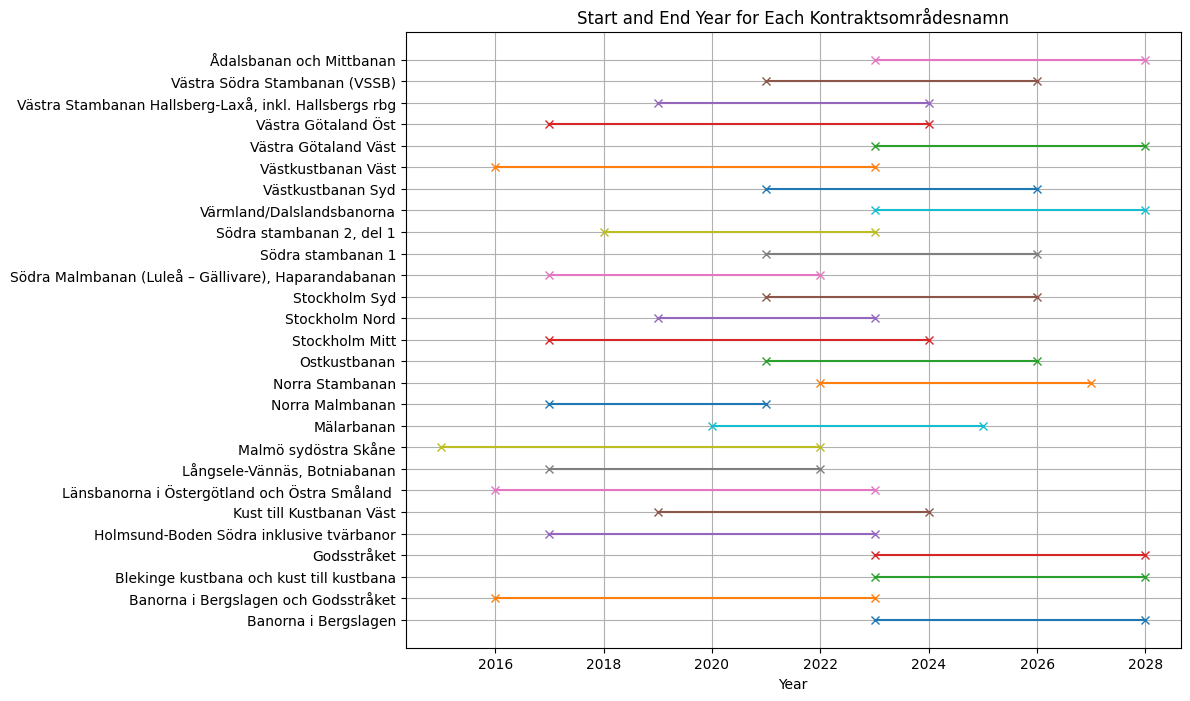

In [56]:
import matplotlib.pyplot as plt

# Group by 'Kontraktsområdesnamn' and get the start and end years
grouped = kontrakt_manual_ai_df.groupby('Kontraktsområdesnamn')[['Year_start', 'Year_end']].first().reset_index()

# Plotting
plt.figure(figsize=(10, 8))
for index, row in grouped.iterrows():
    plt.plot([row['Year_start'], row['Year_end']], [index, index], marker='x')

plt.yticks(range(len(grouped)), grouped['Kontraktsområdesnamn'])
plt.xlabel('Year')
plt.title('Start and End Year for Each Kontraktsområdesnamn')
plt.grid(True)
plt.show()
plt.show()

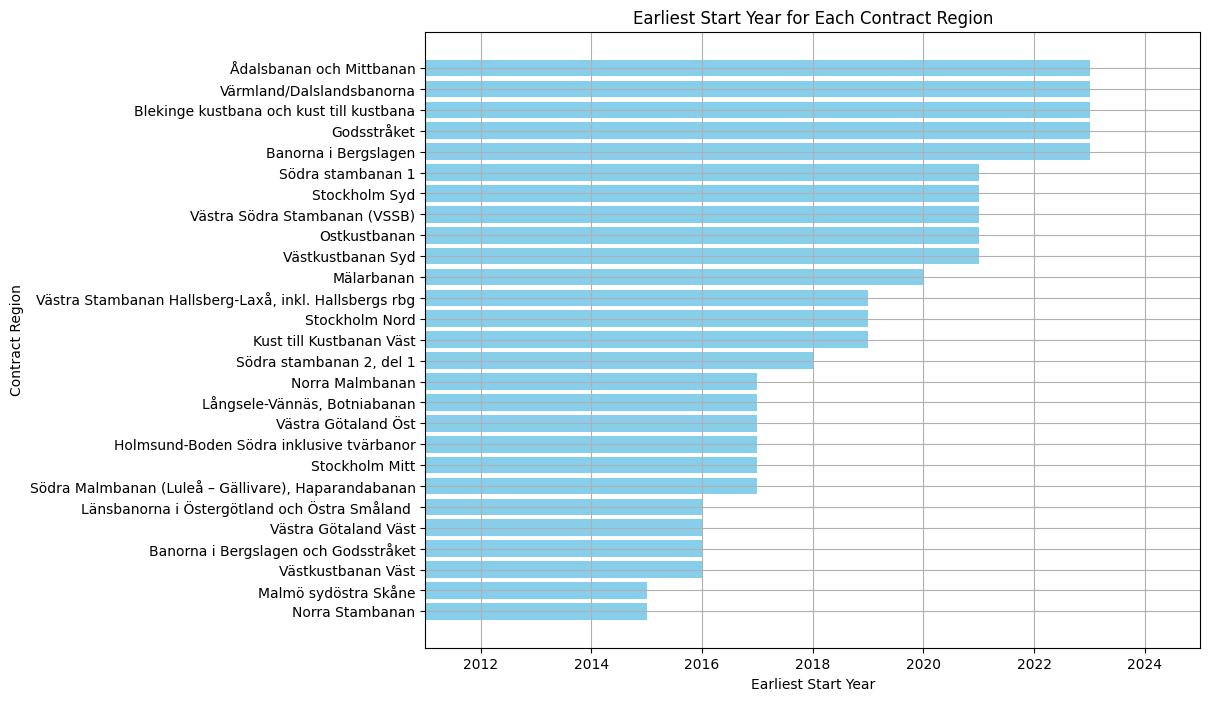

In [57]:
# Group by 'Kontraktsområdesnamn' and get the earliest start year
grouped = kontrakt_manual_ai_df.groupby('Kontraktsområdesnamn')['Year_start'].min().reset_index()

# sort the grouping from the earliest start year to the latest
grouped = grouped.sort_values(by='Year_start')

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(grouped['Kontraktsområdesnamn'], grouped['Year_start'], color='skyblue')
plt.xlabel('Earliest Start Year')
plt.ylabel('Contract Region')
plt.title('Earliest Start Year for Each Contract Region')
plt.grid(True)
plt.xlim(2011, 2025) # rescale the x-axis to be between 2011 and 2025
plt.show()

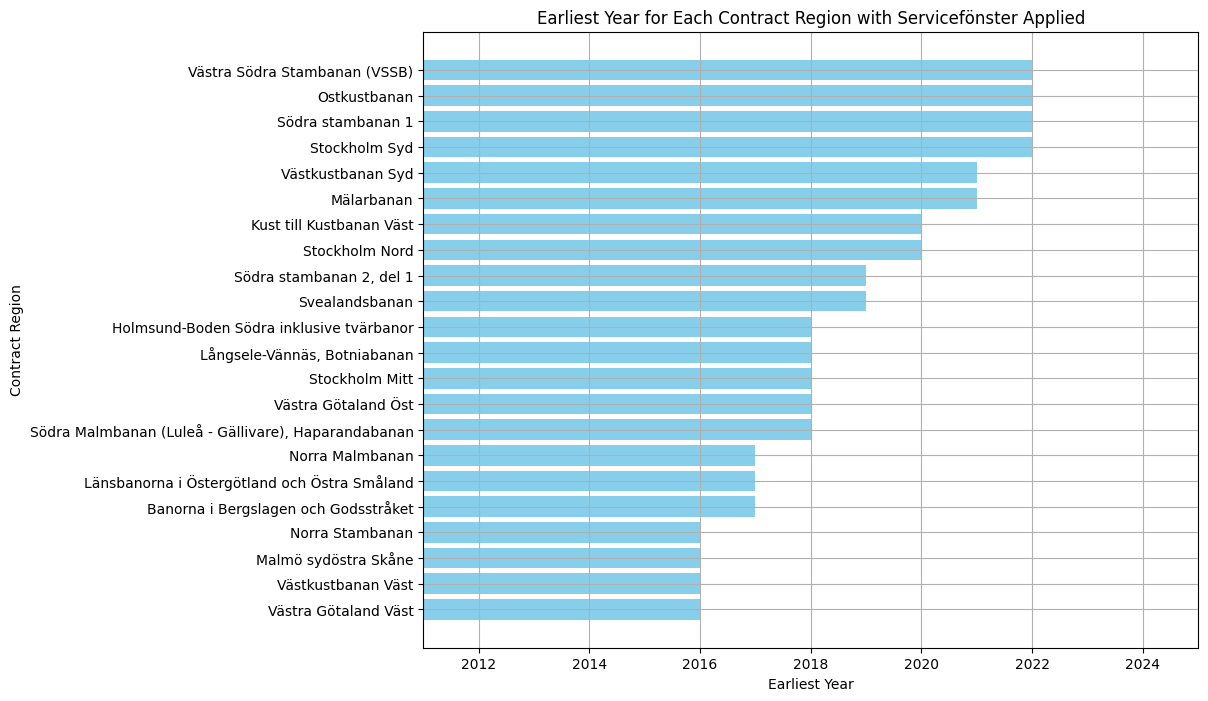

In [58]:
# Filter the dataframe to include only rows where Servicefönster_applied is True
filtered_df = servicekontrakt_df[servicekontrakt_df['Servicefönster_applied'] == True]

# Group by 'Kontraktsområdesnamn' and get the earliest year
grouped_servicekontrakt = filtered_df.groupby('Kontraktsområdesnamn')['Year'].min().reset_index()

# Sort the grouping from the earliest year to the latest
grouped_servicekontrakt = grouped_servicekontrakt.sort_values(by='Year')

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(grouped_servicekontrakt['Kontraktsområdesnamn'], grouped_servicekontrakt['Year'], color='skyblue')
plt.xlabel('Earliest Year')
plt.ylabel('Contract Region')
plt.title('Earliest Year for Each Contract Region with Servicefönster Applied')
plt.grid(True)
plt.xlim(2011, 2025)  # Rescale the x-axis to be between 2011 and 2025
plt.show()

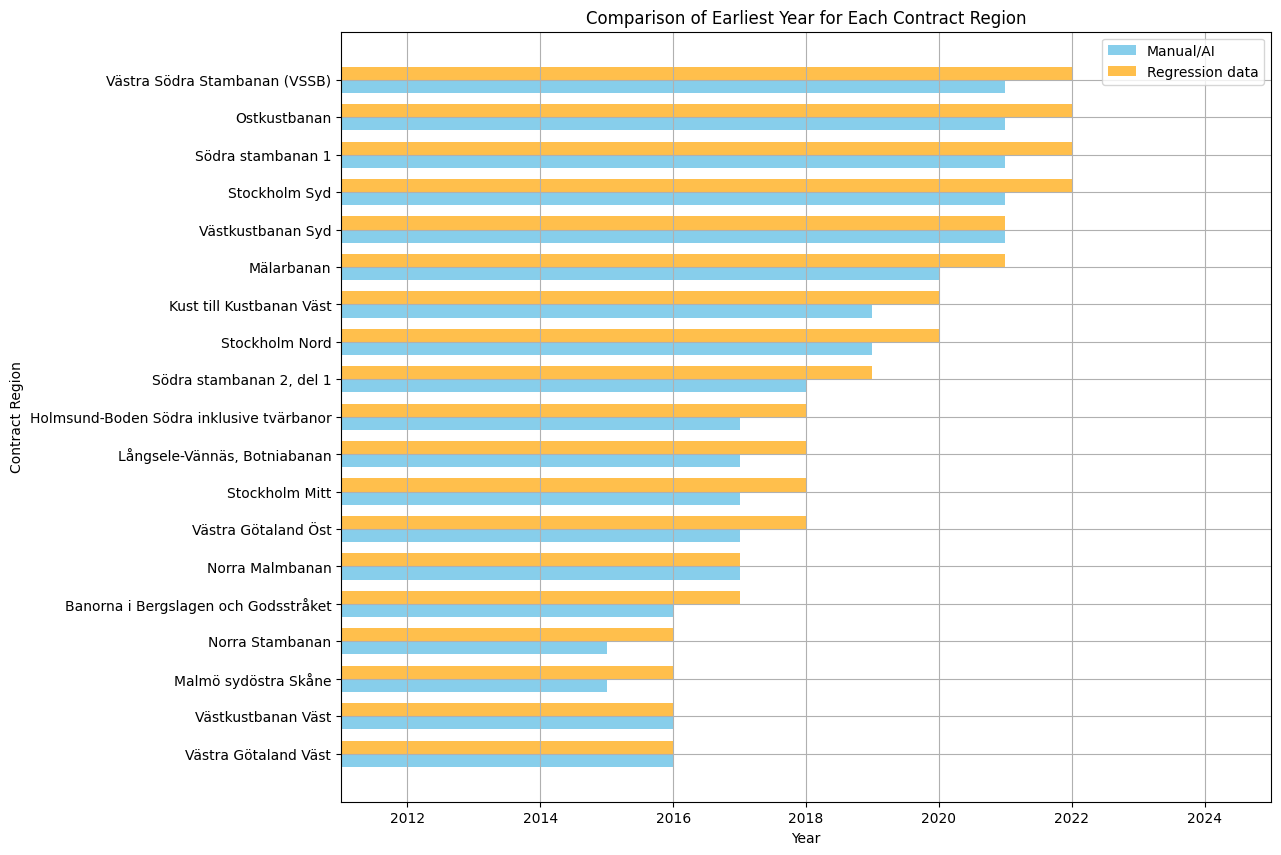

In [60]:
import numpy as np

# Merge the two dataframes on 'Kontraktsområdesnamn'
merged_grouped = pd.merge(grouped_servicekontrakt, grouped[['Kontraktsområdesnamn','Year_start']], on='Kontraktsområdesnamn')

# Create y-positions for the bars
y_pos = np.arange(len(merged_grouped['Kontraktsområdesnamn']))

plt.figure(figsize=(12, 10))

bar_width = 0.35  # Slightly smaller width might look better

# Plot for servicekontrakt - offset downward
plt.barh(y_pos - bar_width/2, merged_grouped['Year_start'], 
         color='skyblue', height=bar_width, label='Manual/AI')

# Plot for manual_ai - offset upward
plt.barh(y_pos + bar_width/2, merged_grouped['Year'], 
         color='orange', height=bar_width, alpha=0.7, label='Regression data')

# Set the y-ticks to be in the middle of the pairs of bars
plt.yticks(y_pos, merged_grouped['Kontraktsområdesnamn'])

plt.xlabel('Year')
plt.ylabel('Contract Region')
plt.title('Comparison of Earliest Year for Each Contract Region')
plt.legend()
plt.grid(True)
plt.xlim(2011, 2025)
plt.show()